In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm import tqdm
import gdown

from aegear.model import EfficientUNet, SiameseTracker
from aegear.datasets import TrackingDataset
from aegear.utils import get_latest_model_path

In [2]:
# 3. Download the data if not already in place
dataset_dir = '../data/training'
video_dir = "../data/video"

annotations = {
    "E7": {
        "file": 'tracking_E7_clean.json',
        "annotation_gdrive_id": "1b8UgWED20Gtkn0ovqizONTlFH-oNYJ_a",
        "video_gdrive_id": "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    },
    "K9": {
        "file": 'tracking_K9_clean.json',
        "annotation_gdrive_id": "12jLIHBySVG3G0Ie52NlmRHQ7U3Sv6ca-",
        "video_gdrive_id": "1iZMfmCJnYsIxBIXqVwRrpubO2-_uItHU"
    },
    "S1": {
        "file": 'tracking_S1_clean.json',
        "annotation_gdrive_id": "1VKNPRTnNb0n5oUBG9hx3ZkLns9CMcs7R",
        "video_gdrive_id": "1aGFLRtPjjiUZjY8k5xH-EKF3sHQSfNnE"
    }
}

# Create directories if they do not exist.
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

bar = tqdm(annotations.items(), desc="Downloading dataset and videos")
for key, annotation_settings in bar:
    bar.set_postfix_str(key)

    annotations_file = os.path.join(dataset_dir, annotation_settings["file"])
    video_file = os.path.join(video_dir, f"{key}.MOV")
    annotation_file_id = annotation_settings["annotation_gdrive_id"]
    video_file_id = annotation_settings["video_gdrive_id"]

    # Check if each of the dataset units is present
    if not os.path.exists(annotations_file):
        print("Downloading dataset...")
        url = f'https://drive.google.com/uc?id={annotation_file_id}'
        gdown.download(url, annotations_file, quiet=False)

    if not os.path.exists(video_file):
        print("Downloading video...")
        url = f'https://drive.google.com/uc?id={video_file_id}'

        gdown.download(url, video_file, quiet=False)

In [3]:
def get_confidence(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return heatmap[0, 0, y, x].item()

def overlay_heatmap_on_rgb(rgb_tensor, heatmap, alpha=0.5, centroid_color=(0, 1, 0)):
    """
    Overlay heatmap onto RGB image and draw a circle at the predicted centroid.
    
    Args:
        rgb_tensor: [3, H, W] tensor
        heatmap: [H, W] numpy array
        alpha: blending weight
        centroid_color: (R, G, B) tuple in range 0–1
    Returns:
        overlay: [H, W, 3] numpy image
    """
    rgb = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    rgb = rgb * 0.229 + 0.485
    rgb = rgb.clip(0, 1)

    heatmap_color = plt.cm.hot(heatmap)[..., :3]
    overlay = (1 - alpha) * rgb + alpha * heatmap_color

    # Find centroid
    flat_idx = heatmap.reshape(-1).argmax()
    h, w = heatmap.shape
    cy = flat_idx // w
    cx = flat_idx % w

    # Draw circle
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    cx_int, cy_int = int(cx), int(cy)
    color_bgr = tuple(int(c * 255) for c in reversed(centroid_color))
    cv2.circle(overlay_uint8, (cx_int, cy_int), 4, color_bgr, thickness=1)

    return overlay_uint8 / 255.0

def save_epoch_visualization(model, val_dataset, epoch, device, output_dir="vis_epochs", N=5, val_seed=42):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    samples = []
    fig, axes = plt.subplots(N, 3, figsize=(9, 3 * N))

    with torch.no_grad():
        for i in range(N):
            random.seed(val_seed)
            template, search, heatmap = val_dataset[i]

            # Move to device, add batch dim
            template_batch = template.unsqueeze(0).to(device)
            search_batch = search.unsqueeze(0).to(device)

            pred = torch.sigmoid(model(template_batch, search_batch))
            confidence = get_confidence(pred)

            # Resize heatmaps to match input size
            target_hm = F.interpolate(heatmap.unsqueeze(0), size=template.shape[-2:], mode='bilinear', align_corners=False).squeeze().numpy()
            pred_hm = F.interpolate(pred, size=template.shape[-2:], mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()

            # Convert to PIL images for visualization
            template_img = TF.to_pil_image(denormalize(template))
            search_img = TF.to_pil_image(denormalize(search))

            # Resize heatmaps to search image size
            search_w, search_h = search_img.size
            pred_hm = cv2.resize(pred_hm, (search_w, search_h), interpolation=cv2.INTER_LINEAR)
            target_hm = cv2.resize(target_hm, (search_w, search_h), interpolation=cv2.INTER_LINEAR)

            # Normalize both
            pred_norm = (pred_hm - pred_hm.min()) / (pred_hm.max() - pred_hm.min() + 1e-8)
            target_norm = (target_hm - target_hm.min()) / (target_hm.max() - target_hm.min() + 1e-8)
            diff_norm = np.abs(pred_norm - target_norm)

            # Overlay prediction on search image
            search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()
            overlay = 0.6 * search_np + 0.4 * plt.cm.jet(pred_norm)[..., :3]
            overlay = np.clip(overlay, 0, 1)

            # Diff image as colormap
            diff_rgb = plt.cm.magma(diff_norm)[..., :3]

            # Plot
            axes[i, 0].imshow(template_img)
            axes[i, 0].set_title("Template")
            axes[i, 1].imshow(overlay)
            axes[i, 1].set_title(f"Pred: {confidence:.2f}")
            axes[i, 2].imshow(diff_rgb)
            axes[i, 2].set_title("Abs Diff")

            for ax in axes[i]:
                ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
    plt.savefig(out_path)
    plt.close()

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

In [4]:
future_frame_seek = list(range(3, 15))
interpolation_smoothness = 5.0

dataset_annotations = [os.path.join(dataset_dir, annotation_settings["file"]) for annotation_settings in annotations.values()]

dataset = ConcatDataset([TrackingDataset(
    tracking_json_path=annotation_file,
    video_dir=video_dir,
    future_frame_seek=future_frame_seek,
    interpolation_smoothness=interpolation_smoothness,
    rotation_range=20,
    scale_range=0.5) for annotation_file in dataset_annotations])

val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.augmentation_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.02, saturation=0.03, hue=0.025),
])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 7609
Validation dataset size: 845


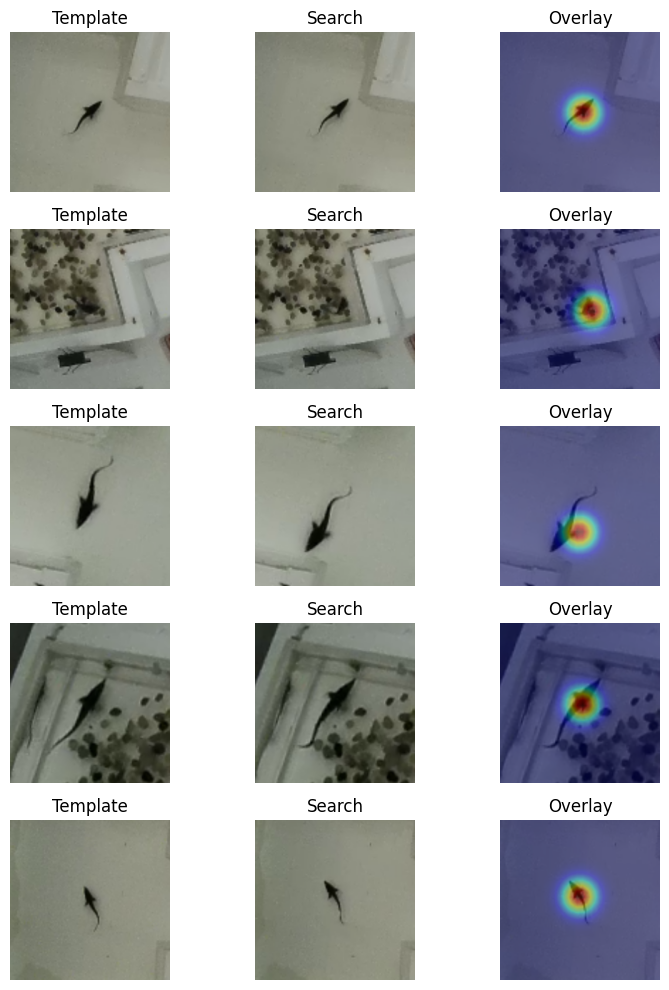

In [5]:
N = 5  # Number of samples to visualize

fig, axes = plt.subplots(N, 3, figsize=(8, 2 * N))

for i in range(N):
    idx = random.randint(0, len(train_dataset) - 1)
    template, search, heatmap = train_dataset[idx]

    template_img = TF.to_pil_image(denormalize(template))
    search_img = TF.to_pil_image(denormalize(search))
    heatmap_np = heatmap.squeeze().numpy()

    # === Resize heatmap
    search_w, search_h = search_img.size  # PIL: size = (W, H)
    heatmap_np = cv2.resize(heatmap_np, (search_w, search_h), interpolation=cv2.INTER_LINEAR)

    # === Normalize heatmap for display
    heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    # === Blend
    search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()
    heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]
    overlay = 0.6 * search_np + 0.4 * heatmap_rgb
    overlay = np.clip(overlay, 0, 1)

    # === Plot
    axes[i, 0].imshow(template_img)
    axes[i, 0].set_title("Template")

    axes[i, 1].imshow(search_img)
    axes[i, 1].set_title("Search")

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Device definition.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Model loaded and moved to device:", device)

# Model settings for training
continue_training = False # Continue training from the latest production model
unlock_unet_encoder = True  # Unlocks the last encoder layer of the EfficientNet for training

# Root model path
model_path = "../data/models"

if continue_training:
   siamese_model_filename = "model_siamese"
   latest_model_stats = get_latest_model_path(model_path, siamese_model_filename)
   model = SiameseTracker()
   model.load_state_dict(torch.load(latest_model_stats, map_location=device))

   print("Continuing training of the Siamese model from:", latest_model_stats)
else:
   efficient_unet_filename = "model_efficient_unet"
   latest_model_stats = get_latest_model_path(model_path, efficient_unet_filename)

   unet = EfficientUNet()
   unet.load_state_dict(torch.load(latest_model_stats, map_location=device))
   unet.eval()

   model = SiameseTracker(unet)

   print("Training a new Siamese model with EfficientNet encoder from:", latest_model_stats)

model.to(device)

for i in range(5):

   if unlock_unet_encoder and i >= 3:
      print(f"Unlocking the encoding layer no. {i+1} for training.")
      continue

   for param in model.encoder[i].parameters():
      param.requires_grad = False

Model loaded and moved to device: cuda
Training a new Siamese model with EfficientNet encoder from: ../data/models\model_efficient_unet_2025-04-04.pth
Unlocking the encoding layer no. 4 for training.
Unlocking the encoding layer no. 5 for training.


In [7]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def weighted_bce_with_logits(pred, target, limit=0.5, pos_weight=10.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

def rgb_consistency_loss(template_img, search_img, pred_heatmap, sigma=2.0, threshold=0.5):
    B, _, H, W = template_img.shape
    device = template_img.device

    # === Upsample predicted heatmap
    pred_heatmap_up = F.interpolate(pred_heatmap, size=(H, W), mode='bilinear', align_corners=False)

    # === Create fixed centered Gaussian for all batch
    grid_y, grid_x = torch.meshgrid(
        torch.linspace(0, H - 1, H, device=device),
        torch.linspace(0, W - 1, W, device=device),
        indexing='ij'
    )
    center_y = (H - 1) / 2
    center_x = (W - 1) / 2
    gaussian = torch.exp(-((grid_x - center_x)**2 + (grid_y - center_y)**2) / (2 * sigma**2))
    gaussian /= gaussian.sum() + 1e-8
    gaussian = gaussian[None, None, :, :]  # shape (1, 1, H, W)

    loss = 0.0
    for i in range(B):
        # === Mask and normalize predicted heatmap
        mask = (pred_heatmap_up[i] > threshold).float()
        weighted_mask = pred_heatmap_up[i] * mask
        weighted_mask /= weighted_mask.sum() + 1e-8  # (1, H, W)

        # === Compute mean RGB in search
        rgb_search = (search_img[i] * weighted_mask).view(3, -1).sum(dim=1)

        # === Compute mean RGB in template using Gaussian
        rgb_template = (template_img[i] * gaussian[0]).view(3, -1).sum(dim=1)

        loss += F.mse_loss(rgb_search, rgb_template)

    return loss / B


In [8]:
model_dir = '../data/models/siamese'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'
epoch_vis = f'{model_dir}/epoch_vis'

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(epoch_vis, exist_ok=True)

In [9]:
# Training loop
best_val_loss = float('inf')
losses = []

epochs = 50
epoch_save_interval = 5

centroid_weight = 0.005  # weight for centroid distance loss
color_weight = 0.25  # weight for color consistency loss

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Training {epoch + 1}", leave=False)
    for template, search, heatmap in train_bar:
        template = template.to(device)
        search = search.to(device)
        target = heatmap.to(device)

        output = model(template, search)

        mse = weighted_bce_with_logits(output, target)
        cdist, distances = centroid_distance_loss(output, target)
        rgb_loss = rgb_consistency_loss(template, search, output)

        loss = (
            mse
            + centroid_weight * cdist
            + color_weight * rgb_loss
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Validation {epoch + 1}", leave=False)

        for template, search, heatmap in val_bar:
            template = template.to(device)
            search = search.to(device)
            target = heatmap.to(device)

            output = model(template, search)

            mse = weighted_bce_with_logits(output, target)
            cdist, distances = centroid_distance_loss(output, target)
            rgb_loss = rgb_consistency_loss(template, search, output)

            loss = (
                mse
                + centroid_weight * cdist
                + color_weight * rgb_loss
            )

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    losses.append((train_loss, val_loss))

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("New best model, saving.")
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))
    
    save_epoch_visualization(model, val_dataset, epoch + 1, device, output_dir=epoch_vis, N=20)


Epoch 1/50 - Train: 0.3007 | Val: 0.2345
New best model, saving.


Epoch 2/50 - Train: 0.2291 | Val: 0.2219
New best model, saving.


Epoch 3/50 - Train: 0.2226 | Val: 0.2170
New best model, saving.


Epoch 4/50 - Train: 0.2203 | Val: 0.2196


Epoch 5/50 - Train: 0.2165 | Val: 0.2118
New best model, saving.


Epoch 6/50 - Train: 0.2148 | Val: 0.2136


Epoch 7/50 - Train: 0.2144 | Val: 0.2093
New best model, saving.


Epoch 8/50 - Train: 0.2122 | Val: 0.2121


Epoch 9/50 - Train: 0.2112 | Val: 0.2082
New best model, saving.


Epoch 10/50 - Train: 0.2124 | Val: 0.2052
New best model, saving.


Epoch 11/50 - Train: 0.2111 | Val: 0.2094


Epoch 12/50 - Train: 0.2100 | Val: 0.2109


Epoch 13/50 - Train: 0.2094 | Val: 0.2070


Epoch 14/50 - Train: 0.2094 | Val: 0.2105


Epoch 15/50 - Train: 0.2087 | Val: 0.2038
New best model, saving.


Epoch 16/50 - Train: 0.2087 | Val: 0.2055


Epoch 17/50 - Train: 0.2095 | Val: 0.2088


Epoch 18/50 - Train: 0.2093 | Val: 0.2052


Epoch 19/50 - Train: 0.2069 | Val: 0.2033
New best model, saving.


Epoch 20/50 - Train: 0.2078 | Val: 0.2057


Epoch 21/50 - Train: 0.2086 | Val: 0.2069


Epoch 22/50 - Train: 0.2070 | Val: 0.2023
New best model, saving.


Epoch 23/50 - Train: 0.2071 | Val: 0.2049


Epoch 24/50 - Train: 0.2068 | Val: 0.2055


Epoch 25/50 - Train: 0.2065 | Val: 0.2098


Epoch 26/50 - Train: 0.2080 | Val: 0.2091


Epoch 27/50 - Train: 0.2060 | Val: 0.2040


Epoch 28/50 - Train: 0.2064 | Val: 0.2021
New best model, saving.


Epoch 29/50 - Train: 0.2059 | Val: 0.2060


Epoch 30/50 - Train: 0.2058 | Val: 0.2034


Epoch 31/50 - Train: 0.2065 | Val: 0.2101


Epoch 32/50 - Train: 0.2059 | Val: 0.2038


Epoch 33/50 - Train: 0.2059 | Val: 0.2032


Epoch 34/50 - Train: 0.2059 | Val: 0.2111


Epoch 35/50 - Train: 0.2056 | Val: 0.2021
New best model, saving.


Epoch 36/50 - Train: 0.2049 | Val: 0.2039


Epoch 37/50 - Train: 0.2048 | Val: 0.2061


Epoch 38/50 - Train: 0.2056 | Val: 0.2042


Epoch 39/50 - Train: 0.2046 | Val: 0.2051


Epoch 40/50 - Train: 0.2048 | Val: 0.2031


Epoch 41/50 - Train: 0.2039 | Val: 0.2058


Epoch 42/50 - Train: 0.2040 | Val: 0.2047


Epoch 43/50 - Train: 0.2032 | Val: 0.2050


Epoch 44/50 - Train: 0.2037 | Val: 0.2086


Epoch 45/50 - Train: 0.2030 | Val: 0.2050


Epoch 46/50 - Train: 0.2027 | Val: 0.2057


Epoch 47/50 - Train: 0.2037 | Val: 0.2034


Epoch 48/50 - Train: 0.2036 | Val: 0.2015
New best model, saving.


Epoch 49/50 - Train: 0.2033 | Val: 0.2036


Epoch 50/50 - Train: 0.2039 | Val: 0.2068


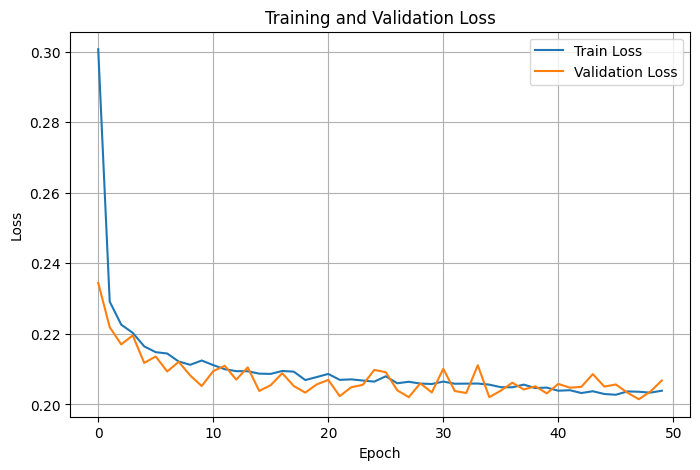

In [10]:
# 7. Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))
model.eval()
model.to(device);

In [12]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for templates, searches, heatmaps in tqdm(val_loader, desc="Evaluating"):
        templates = templates.to(device)
        searches = searches.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(templates, searches))

        heatmaps = F.interpolate(heatmaps, size=templates.shape[2:], mode='bilinear', align_corners=False)
        preds = F.interpolate(preds, size=templates.shape[2:], mode='bilinear', align_corners=False)

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(templates)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()

            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = searches[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


Evaluating: 100%|██████████| 27/27 [01:09<00:00,  2.57s/it]


Average centroid distance: 9.15 px, Average confidence: 0.93
Within 3px: 23.79%
Within 5px: 23.79%
Within 10px: 66.15%


In [13]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    xc, yc = img_disp.shape[1] // 2, img_disp.shape[0] // 2

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT', marker='o')
    axs[0].scatter([xp], [yp], c='red', label='Pred', marker='o')
    axs[0].scatter([xc], [yc], c='green', label='Template', marker='x')
    
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

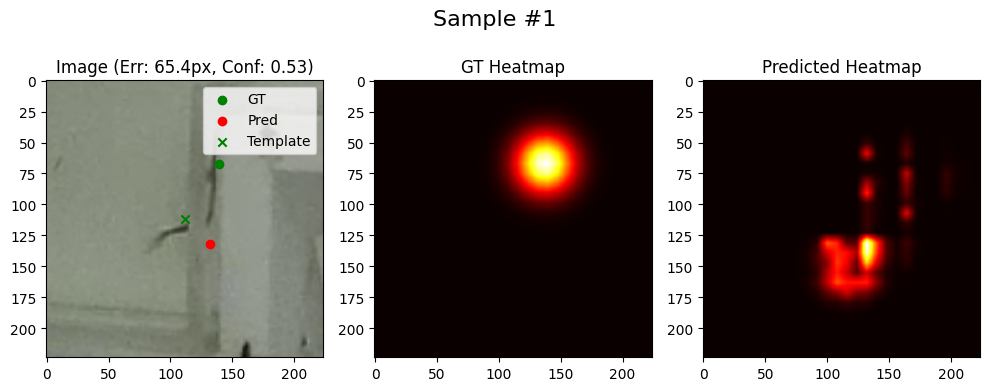

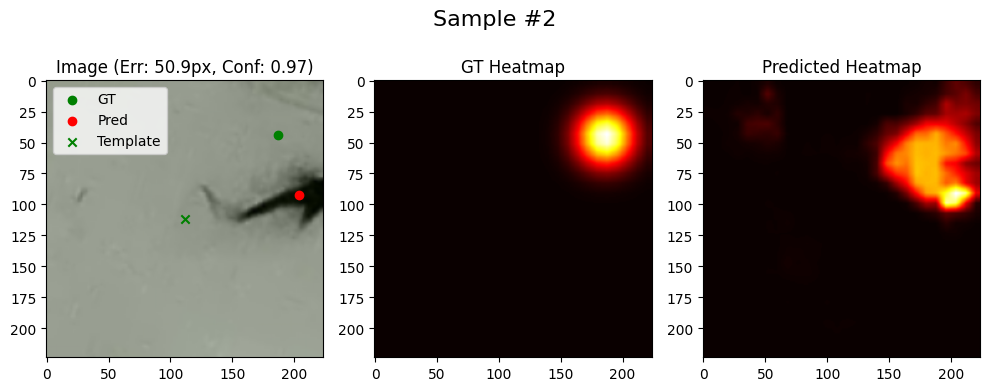

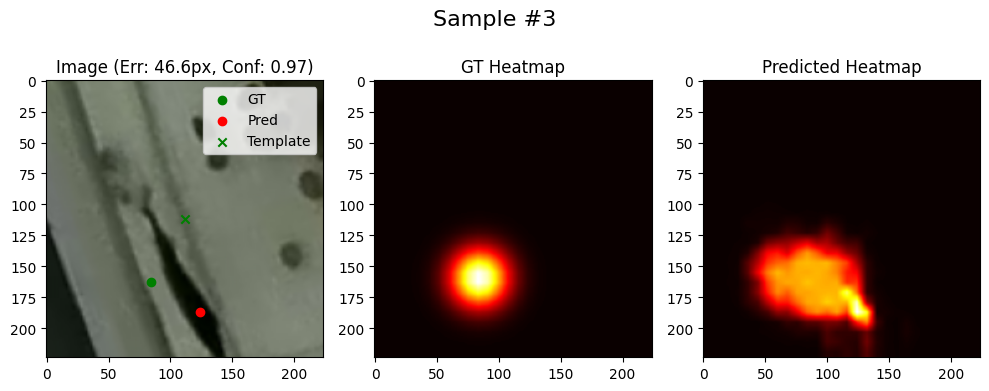

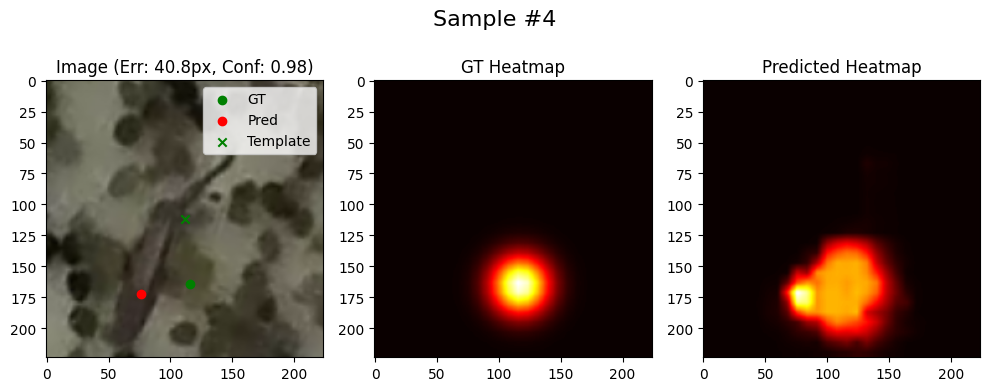

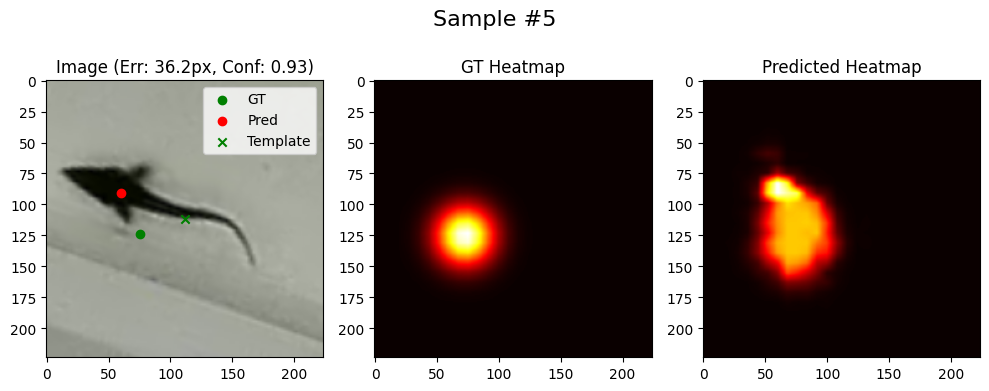

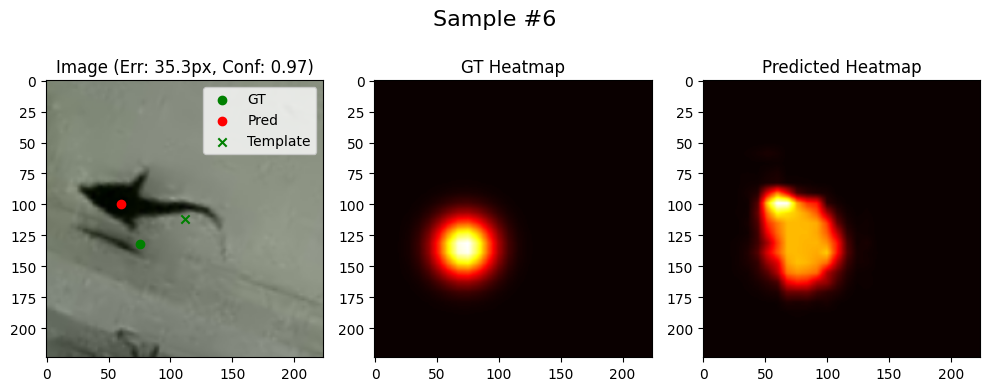

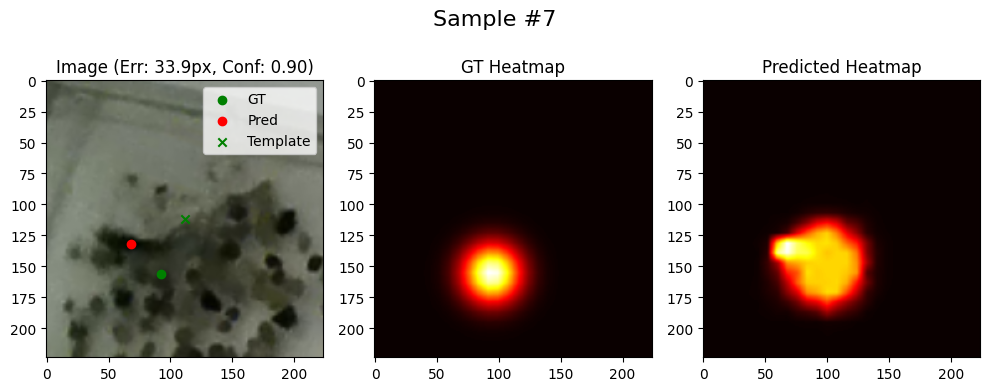

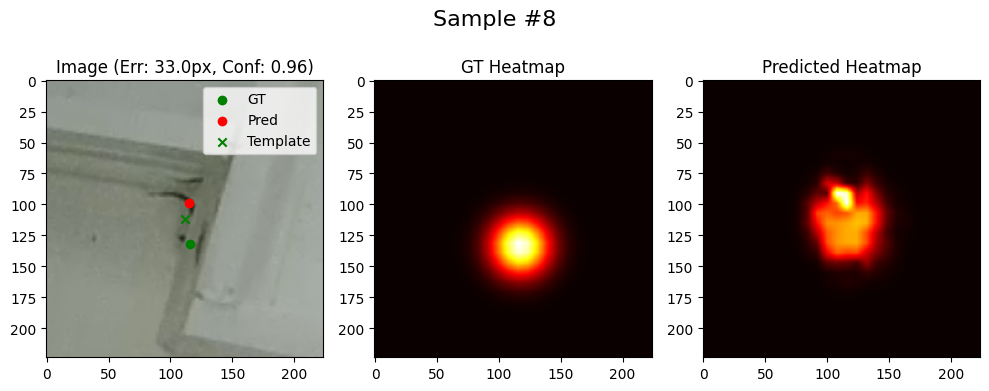

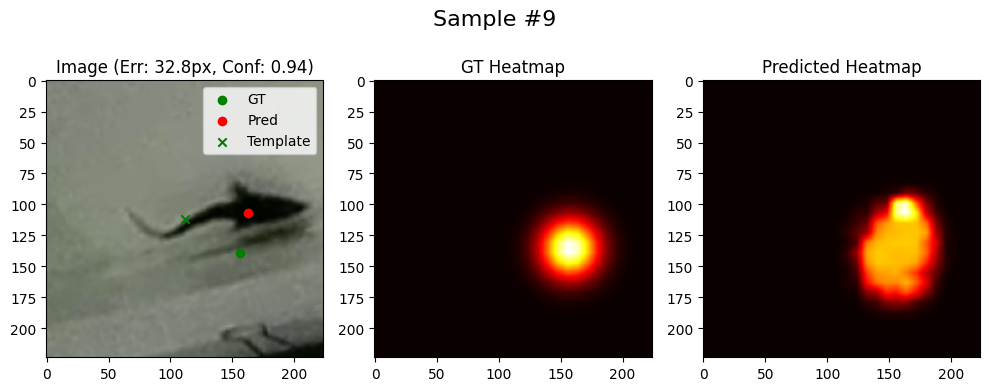

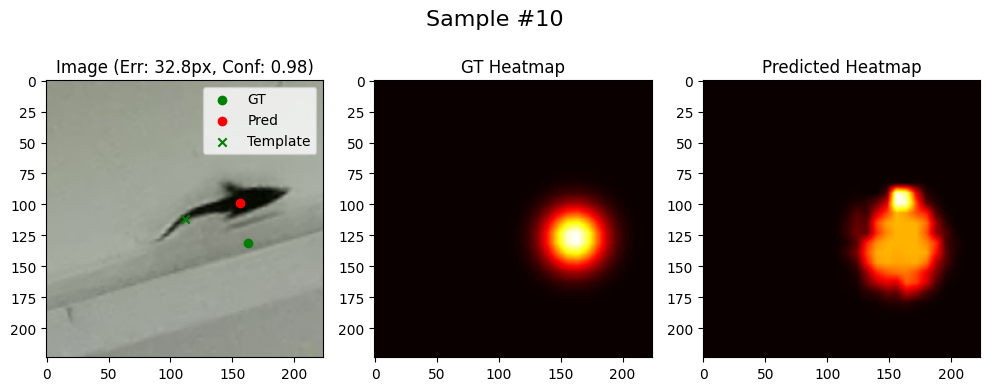

In [14]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

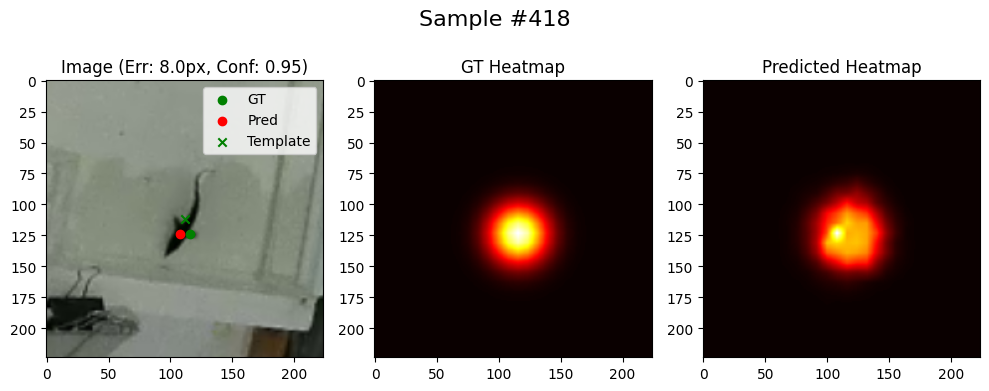

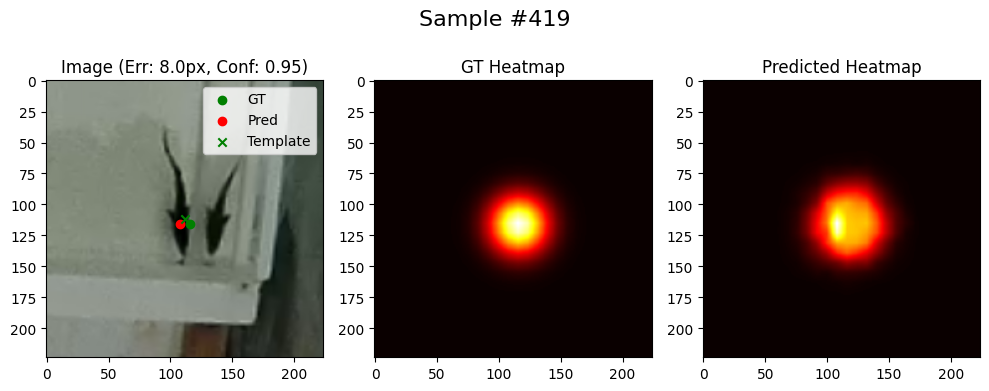

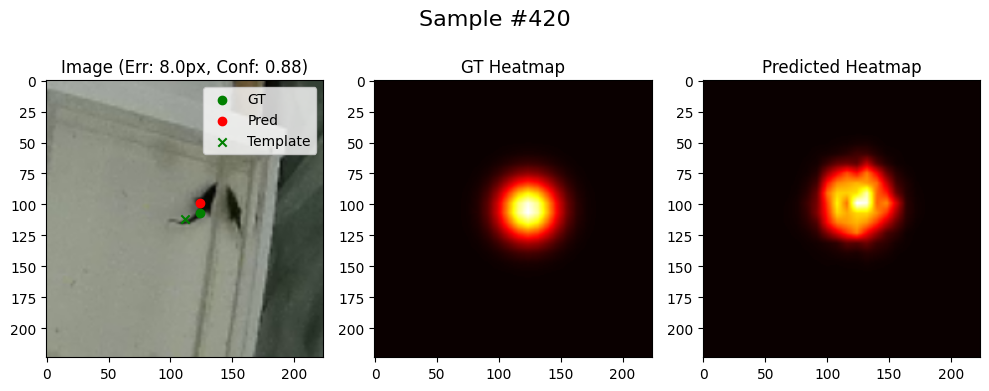

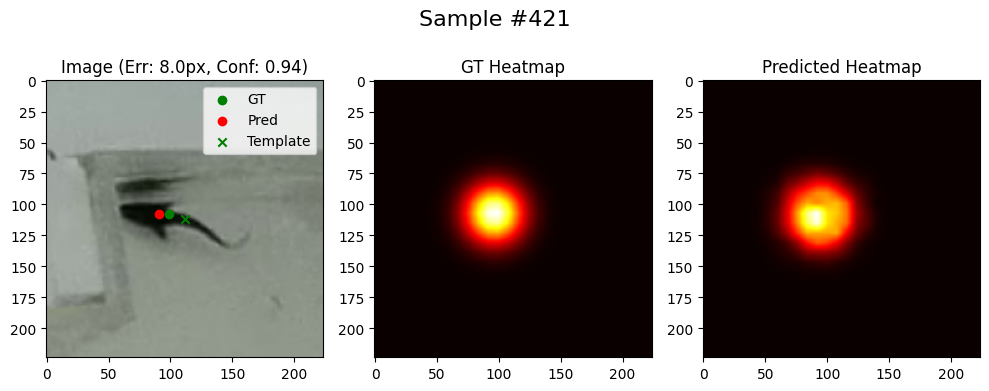

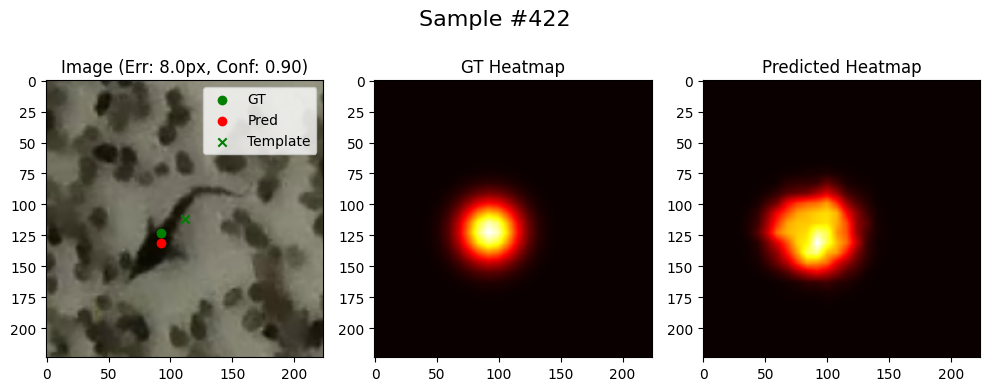

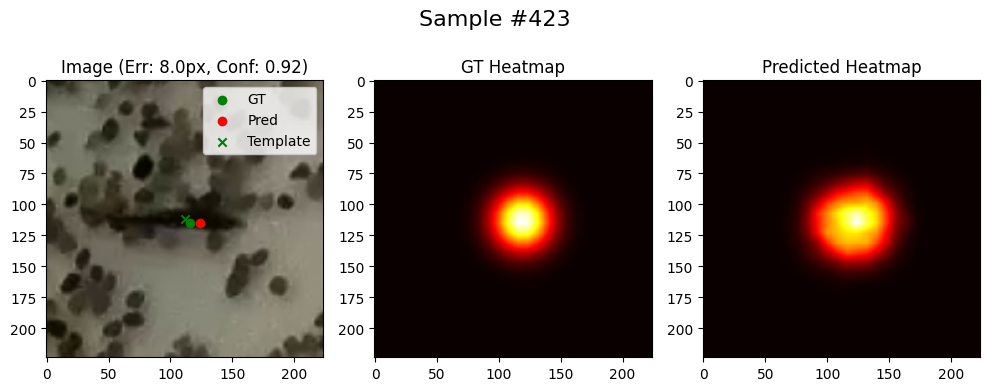

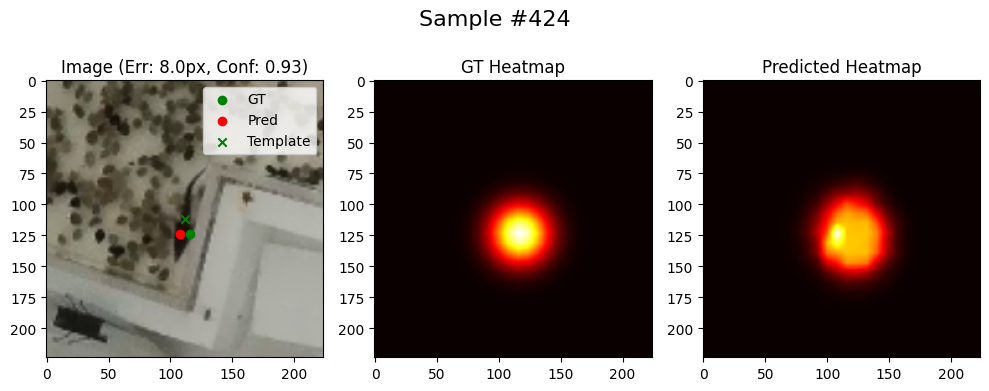

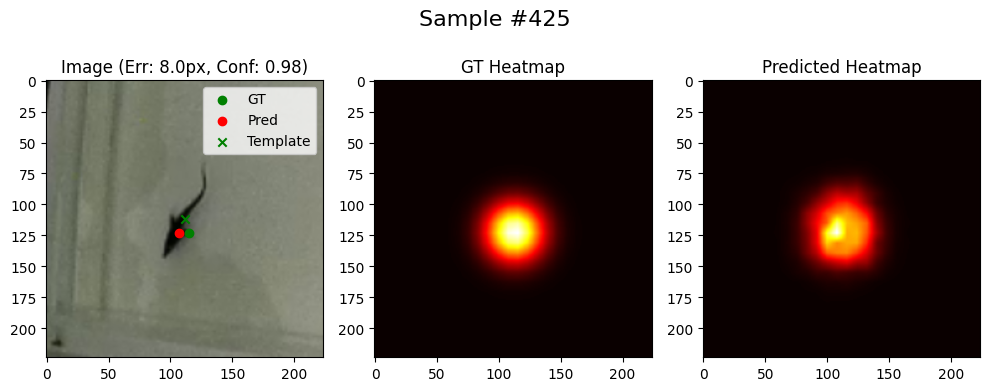

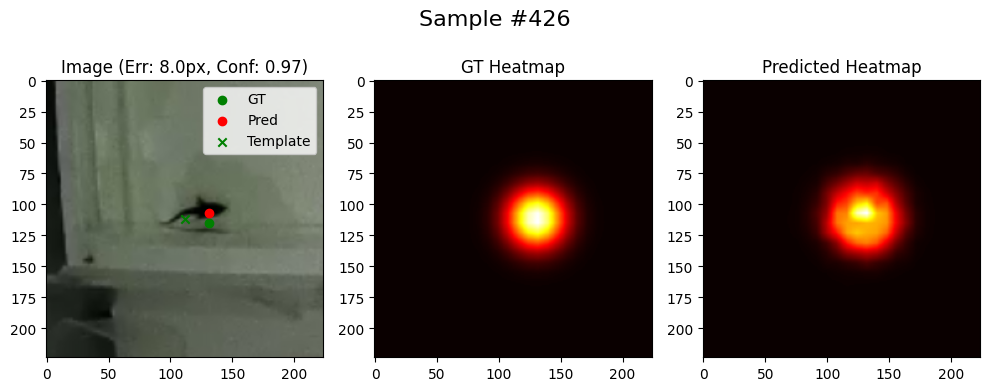

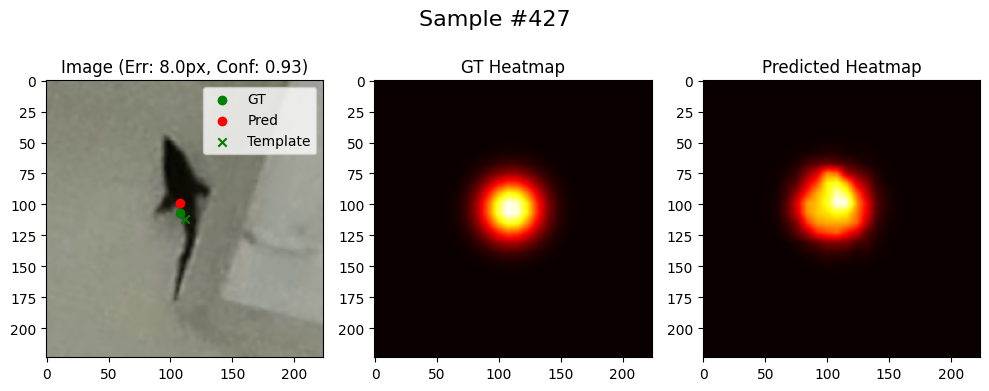

In [15]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

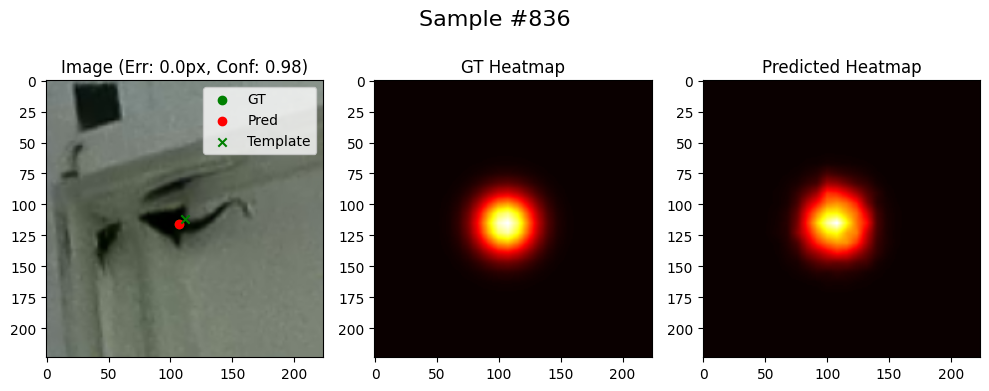

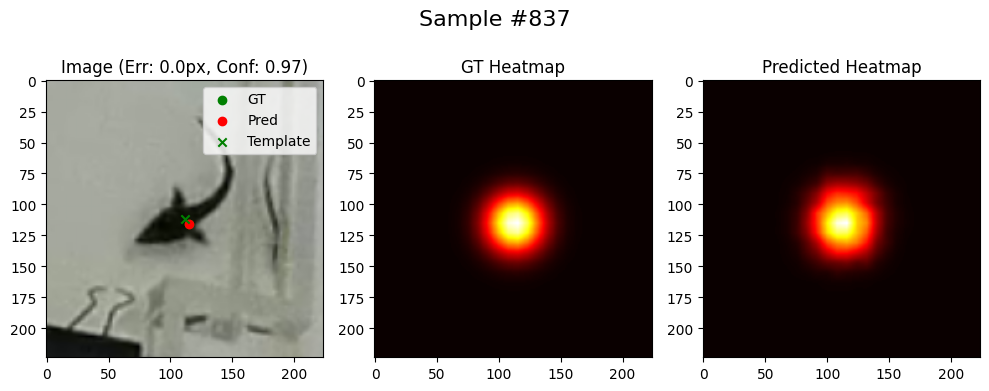

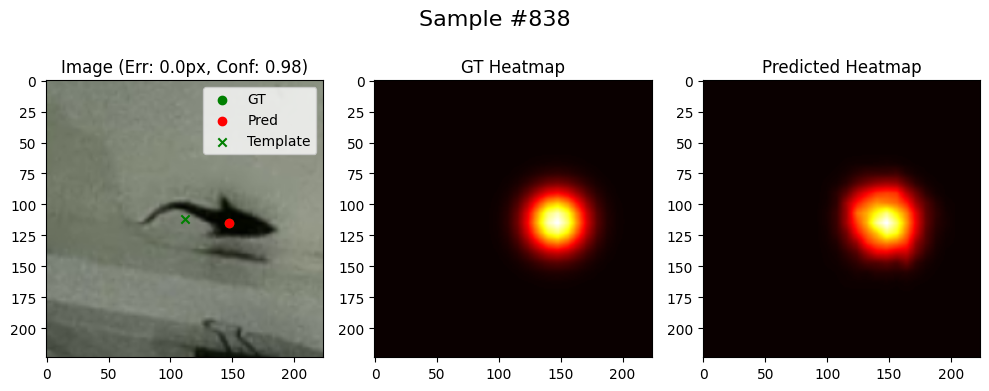

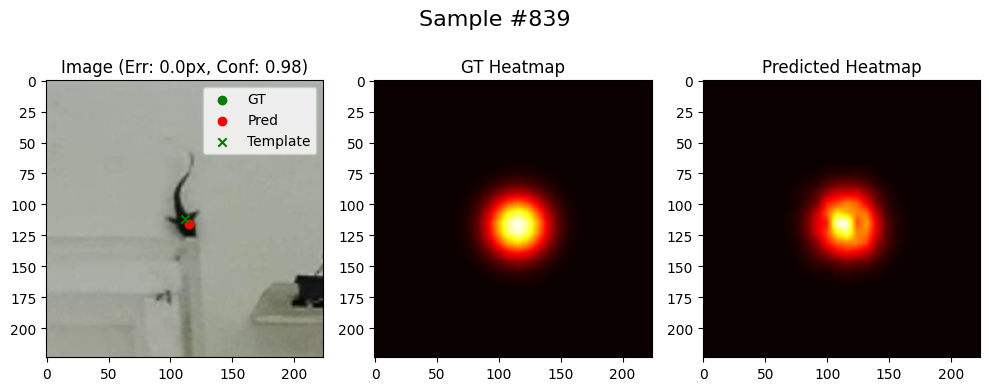

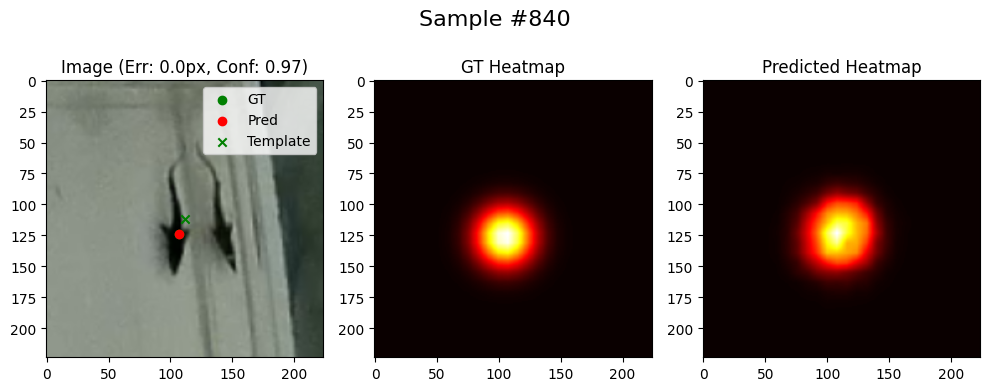

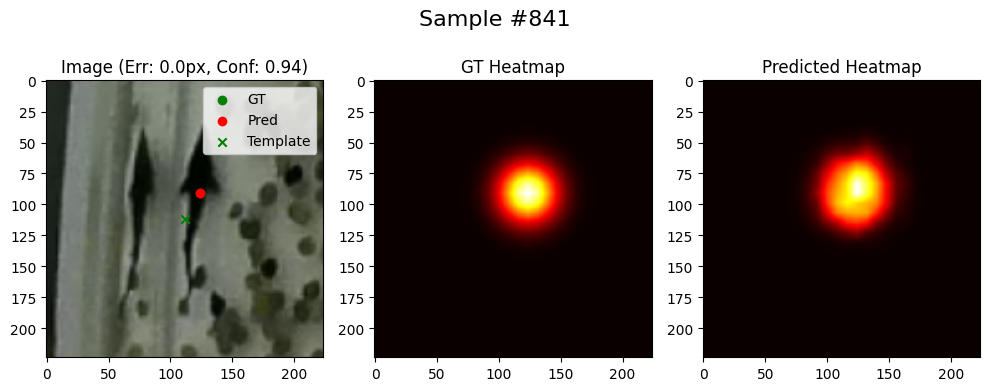

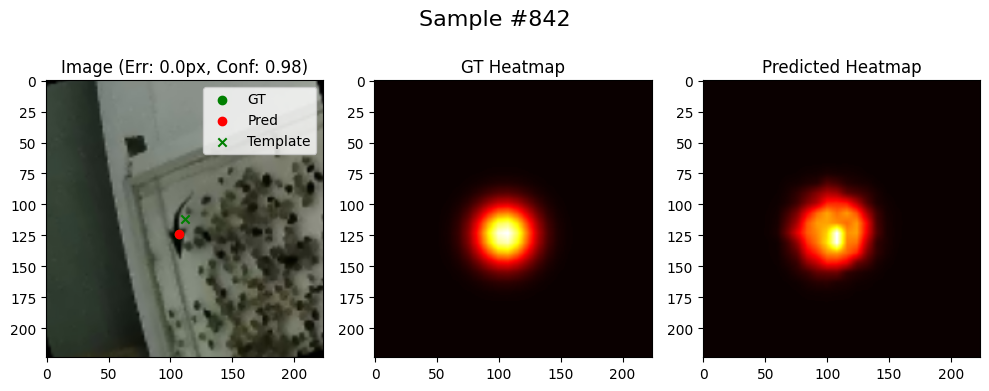

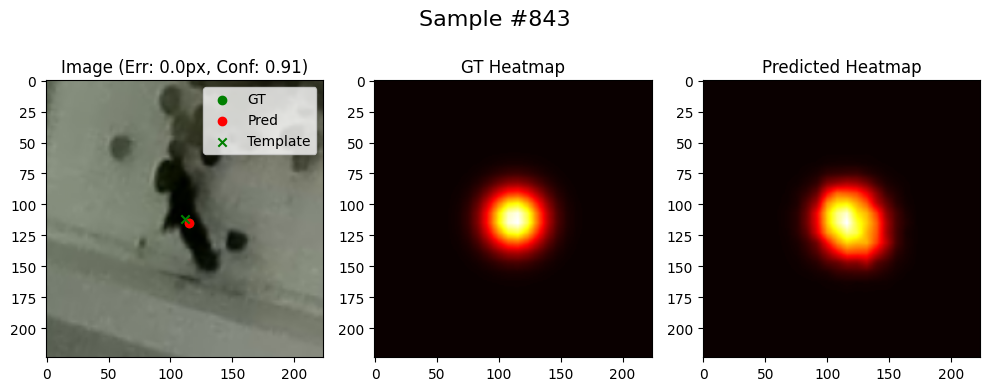

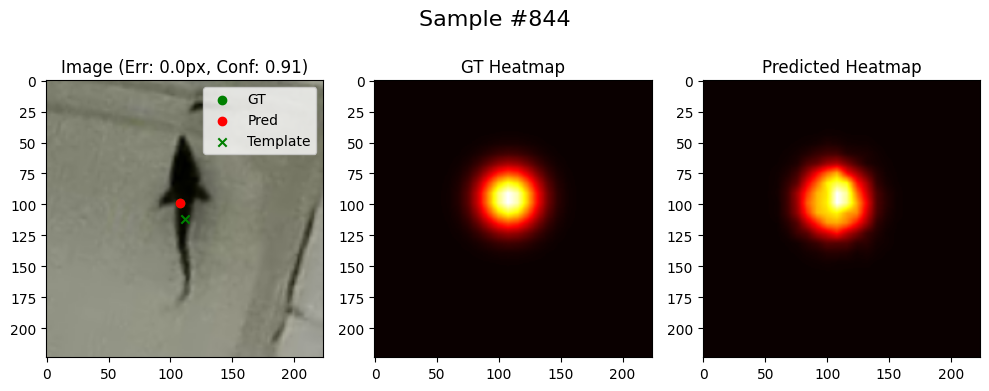

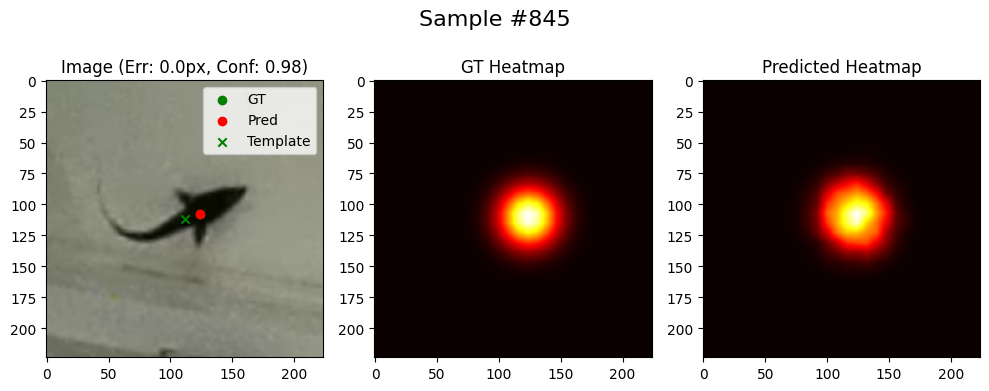

In [16]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)